Restaurants Recommendations
==============
This is a recomendation system for restaurants using collaborative filtering (CF). There are two primary approaches to CF: neighborhood (similarities between items or users) and latent factor model (hidden factors through which users and items are transformed into the same space). [reference](https://github.com/cs109/content/blob/master/HW4_solutions.ipynb)

The outline of this project is as follows:
- Create a database of item-item similarities. 
- Predict the rating that a user will give an item they have never seen before. 
- Implement a factor-based CF recommendar using a Bayesian model. 

About 7000 reviews from the complete data set with 150,000 reviews will be used. This subset is limited to all the users who had rated more than 60 restaurants, and all the businesses which had greater than 150 reviews.   

In [1]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

plt.style.use('ggplot')

/Users/amywu/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Description of the data set
------------------
The data set has been extracted from the Yelp Phoenix restaurants dataset. 

In [2]:
fulldf=pd.read_csv('bigdf.csv')
fulldf.head(2)

,user_id,business_id,date,review_id,stars,usefulvotes_review,user_name,categories,biz_name,latitude,longitude,business_avg,business_review_count,user_avg,user_review_count
0,rLtl8ZkDX5vH5nAx9C3q5Q,9yKzy9PApeiPPOUJEtnvkg,2011-01-26 00:00:00,fWKvX83p0-ka4JS3dc6E5A,5,5,Jason,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.796954,197
1,SBbftLzfYYKItOMFwOTIJg,9yKzy9PApeiPPOUJEtnvkg,2008-05-04 00:00:00,DASdFe-g0BgfN9J2tanStg,5,1,Jennifer,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.473684,57


The data frame is a frame of reviews.

- The information for the reviews themselves:
stars': (star rating, integer 1-5), 'date': (date, formatted like '2011-04-19'), 'review_id': (unique id for the review).

- The information on the business sized: 
'business_id': (a unique identifier for this business), 'biz_name': (the full business name), 'latitude': (latitude), 'longitude': (longitude), 'business_review_count': (review count for the restaurant[this is a repeated field for all reviews of the restaurant]), 'categories': [(localized category names)], 'business_avg': (average stars over all users reviews for business[this is a repeated field for all reviews of the restaurant]).

- The information about users:
'user_id': (unique user identifier), 'user_name': (first name, last initial, like 'Matt J.'), 'user_review_count': (count of restaurants reviewed by user[this is a repeated field for all reviews by the user]), 'user_avg': (floating point average of users reviews over all businesses, like 4.31[this is a repeated field for all reviews by the user]).


Find similarity
---------
The baseline estimate of a restaurant $ \hat{Y_{um}}$ is equal to the total average rating of all restaurants, plus the average rating of this paricular restaurant $m$ above total average rating, plus the average rating of this particular user $u$ above total average rating. For example, we assume the average rating of all restaurants at Princeton is 3.5. Tomo Sushi is better than an average restaurant by 0.5 above the average. However, Woodrow Wilson tends to rate 0.2 stars below the average. Then the baseline estimate for the recommendation for Tomo Sushi for Woodrow Wilson is $3.5+0.5-0.2=3.8$.

We can estimate unknow rating $Y_{um}$ for user $u$ or business $m$ as:
$$ \hat{Y_{um}} = \hat Y_{um}^{baseline}\, + \,\frac{\sum\limits_{j \in S^{k}(m)} s_{mj} ( Y_{uj} - \hat Y_{uj}^{baseline} )}{\sum\limits_{j \in S^{k}(m)} s_{mj} } $$

where $S^{k}(m)$ is the $k$ neighbor items (which have been rated by user $u$) of item $m$, $s_{mj}$ is the similarity measured via **Pearson's coefficient**.

1. Global recommender
====
Calculate the similarity betweeen items and rank the nearest neighbors of an item by this similarity based on the 'global' assumption that every user perceives the similarity between restaurants in the same way.  

1.1 Exploratory data analysis
------

In [3]:
print "Number of reviews",fulldf.shape[0]
print "Number of users",fulldf.user_id.unique().shape[0]
print "Number of business", fulldf.business_id.unique().shape[0]

Number of reviews 149319
Number of users 34789
Number of business 4503


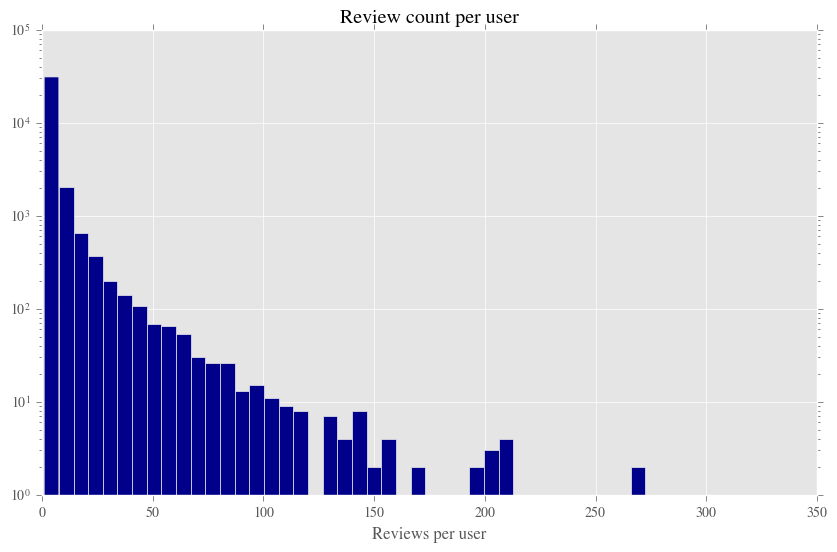

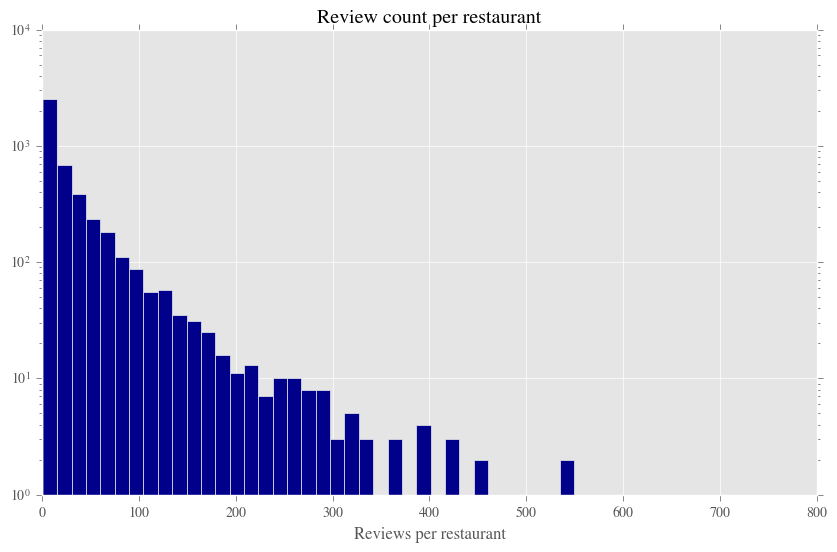

In [4]:
plt.figure()
# Visualize number of reviews per user 
urc=fulldf.groupby('user_id').review_id.count()
ax=urc.hist(bins=50, log=True, color='DarkBlue')
plt.xlabel("Reviews per user")
plt.title("Review count per user")

# Visualize number of reviews per restaurant
plt.figure()
brc=fulldf.groupby('business_id').review_id.count()
ax=brc.hist(bins=50, log=True, color='DarkBlue')
plt.xlabel("Reviews per restaurant")
plt.title("Review count per restaurant")

Average rating of reviews  3.74141268023


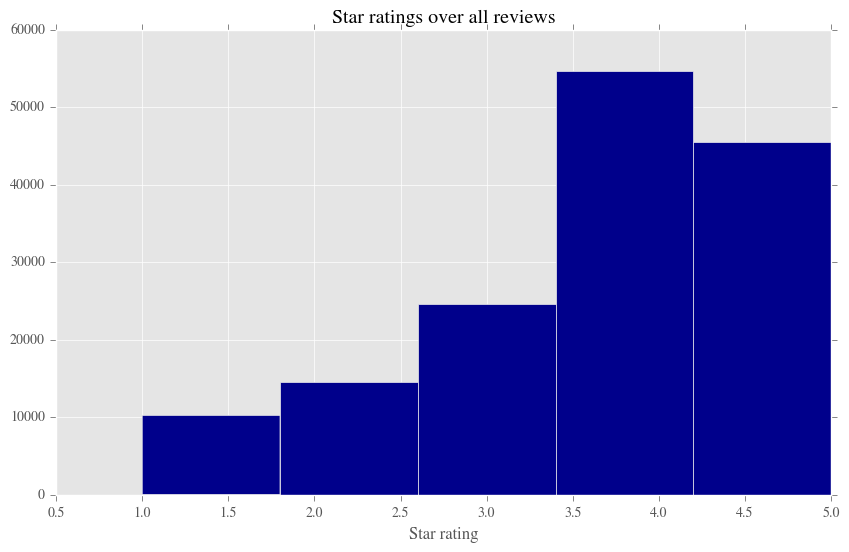

In [5]:
print "Average rating of reviews ", fulldf.stars.mean()
ax=fulldf.stars.hist(bins=5, color='DarkBlue')
plt.xlabel("Star rating")
plt.title("Star ratings over all reviews")

In [6]:
def Recompute_Frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all averages and review counts recomputed
    this is used when a frame is subsetted.
    """
    ldfu=ldf.groupby('user_id')
    ldfb=ldf.groupby('business_id')
    user_avg=ldfu.stars.mean()
    user_review_count=ldfu.review_id.count()
    business_avg=ldfb.stars.mean()
    business_review_count=ldfb.review_id.count()
    nldf=ldf.copy()
    # new features
    nldf.set_index(['business_id'], inplace=True)
    nldf['business_avg']=business_avg
    nldf['business_review_count']=business_review_count
    nldf.reset_index(inplace=True)
    nldf.set_index(['user_id'], inplace=True)
    nldf['user_avg']=user_avg
    nldf['user_review_count']=user_review_count
    nldf.reset_index(inplace=True)
    return nldf

Now create a smaller data set with the following criteria: those businesses with more than 150 reviews and those users with more than 60 reviews. Then use the function `recompute_frame` to recalculate the averages and counts. 

In [7]:
smalldftemp=fulldf[(fulldf.user_review_count > 60) & (fulldf.business_review_count > 150)]
smalldf=Recompute_Frame(smalldftemp)

Total number of reviews 6165
Users in this set 240
Restaurants in this set 240


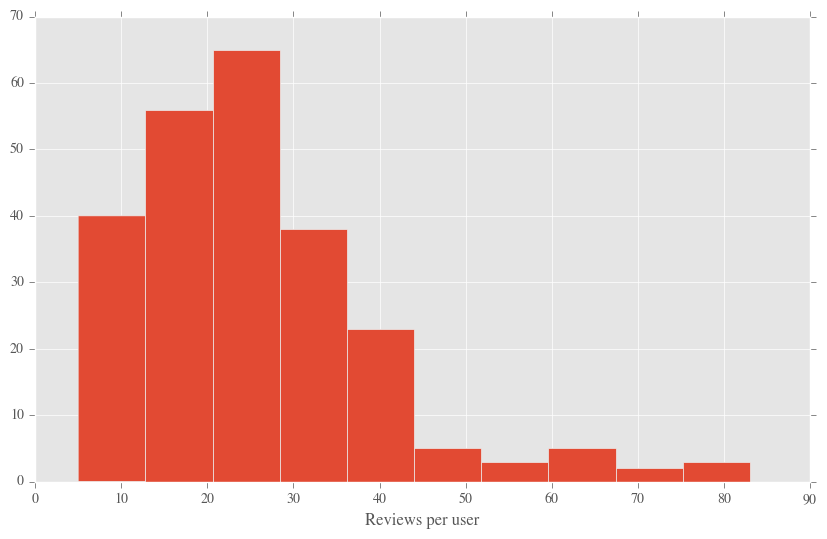

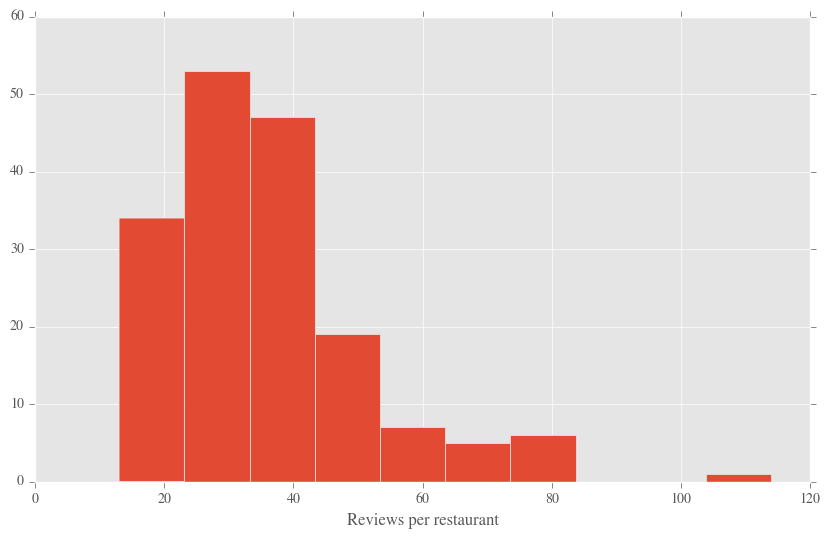

In [8]:
print 'Total number of reviews', smalldf.shape[0]
print 'Users in this set', smalldf.user_id.unique().shape[0]
print 'Restaurants in this set', smalldf.user_id.unique().shape[0]

# Visualize number of reviews per user and per restaurant
plt.figure()
ax=smalldf.groupby('user_id').review_id.count().hist()
plt.xlabel("Reviews per user")
plt.figure()
ax=smalldf.groupby('business_id').review_id.count().hist()
plt.xlabel("Reviews per restaurant")

Average rating 3.86763990268


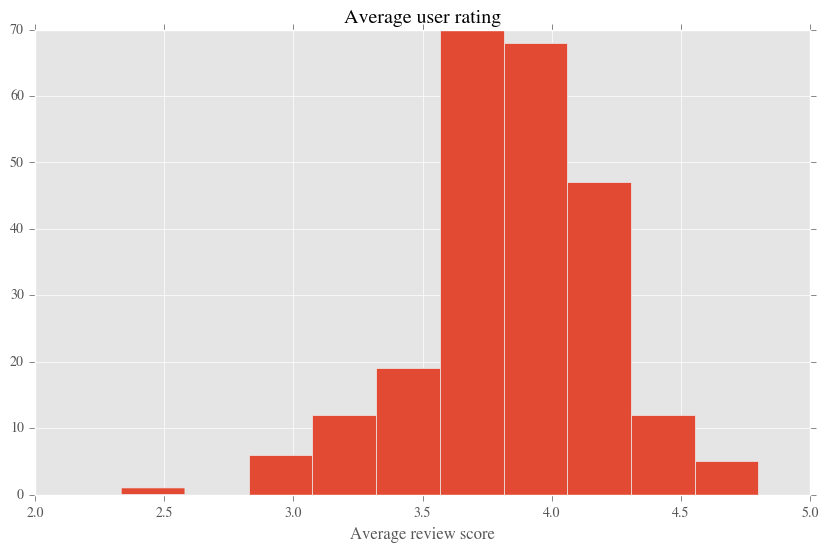

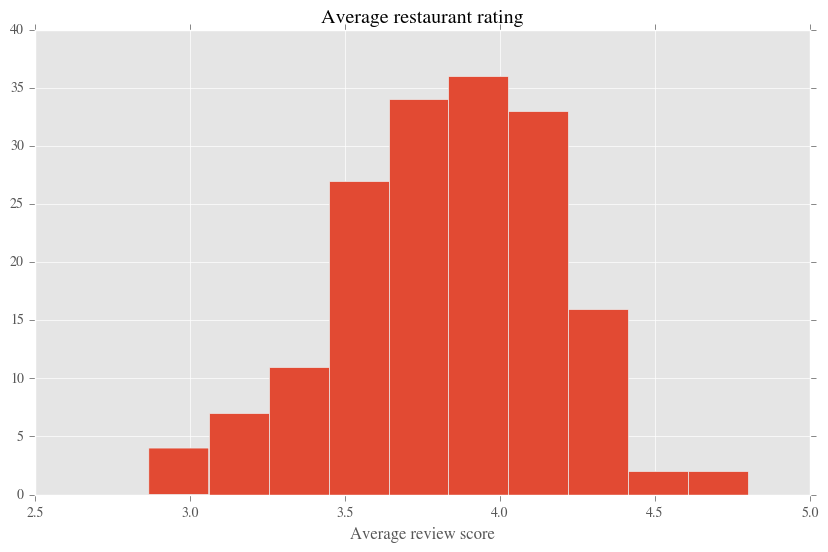

In [9]:
plt.figure()
avg_ratings_by_user=smalldf.groupby('user_id').stars.mean()
ax=avg_ratings_by_user.hist()
plt.xlabel("Average review score")
plt.title("Average user rating")

plt.figure()
avg_ratings_by_rest=smalldf.groupby('business_id').stars.mean()
ax=avg_ratings_by_rest.hist()
plt.xlabel("Average review score")
plt.title("Average restaurant rating")

print "Average rating", smalldf.stars.mean()

1.2 The common user support
---------
For each pair of restaurants, find the number of people who reviewed both. If the common support is low, the similarity is less believable.  

Mean support is 6.84679722562


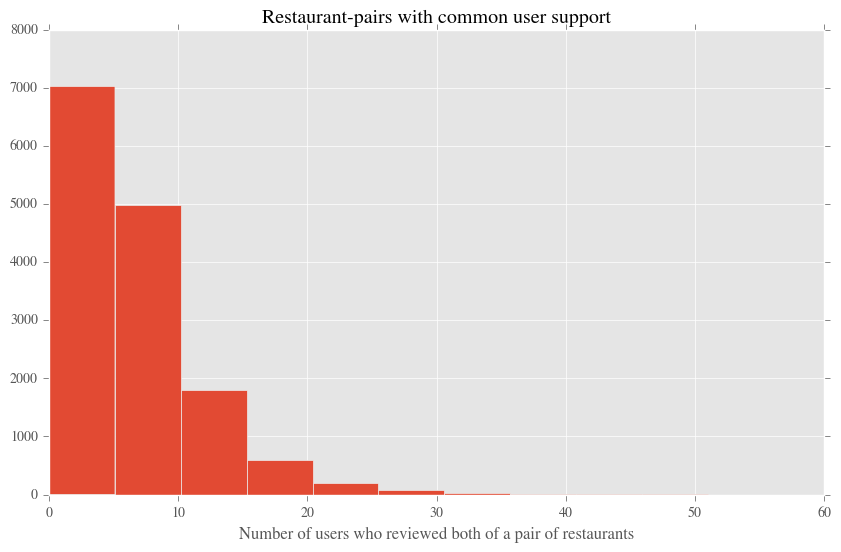

In [10]:
restaurants=smalldf.business_id.unique()
supports=[]
for i, restA in enumerate(restaurants):
    for j, restB in enumerate(restaurants):
        if i < j:
            restA_reviewers = smalldf[smalldf.business_id==restA].user_id.unique()
            restB_reviewers = smalldf[smalldf.business_id==restB].user_id.unique()
            common_reviewers = set(restA_reviewers).intersection(restB_reviewers)
            supports.append(len(common_reviewers)) 
print "Mean support is", np.mean(supports) # average number of common support users
plt.hist(supports)
plt.xlabel('Number of users who reviewed both of a pair of restaurants')
plt.title('Restaurant-pairs with common user support')

Even though we chosa subset of the dataframe in which every restaurant had 150 reviews and every user had atleast made 60, the common support of most pairs of restaurants is really low, indeed less than 10.

1.3 Calculating similarity
------------
We need to subtract the average rating of the user from the actual rating of the restaurants in computing the similarity of two restaurants, using the function `Pearson_Sim` defined below. This makes the ratings by two different users comparable. 

The similarity is set to 0 if there is no common support (users who rated both restaurants). 

In [11]:
from scipy.stats.stats import pearsonr
def Pearson_Sim(restA_rev, restB_rev, n_common):
    """
    Given a subframe of restaurant 1 reviews and a subframe of restaurant 2 reviews,
    where the reviewers are those who have reviewed both restaurants, return 
    the pearson correlation coefficient between the user average subtracted ratings.
    The case for zero common reviewers is handled separately. Its
    ok to return a NaN if any of the individual variances are 0.
    """
    if n_common==0:
        rho=0.
    else:
        diffA=restA_rev['stars']-restA_rev['user_avg']
        diffB=restB_rev['stars']-restB_rev['user_avg']
        rho=pearsonr(diffA, diffB)[0]
    return rho

The function `Get_Restaurant_Rev` defined below takes a restaurant `business_id` and a set of users, and returns the reviews of that restaurant by those users. 

In [12]:
def Get_Restaurant_Rev(restaurant_id, df, set_of_users):
    """
    Given a restaurant id and a set of reviewrs, return the sub-dataframe of their reviews.
    """
    reviews=df[(df['business_id']==restaurant_id) & (df['user_id'].isin(set_of_users))]
    return reviews[reviews['user_id'].duplicated()==False]

Define a function `Calculate_Simularity` which operates as below:
1. For each of the two restaurants, get the set of reviewers who have reviewed the restaurant and compute the intersection of these two sets. Also compute the number of common reviewers n_common.
2. Use the function get_restaurant_reviews defined below to get the reviews for each restaurant as made by these common reviewers. Notice that get_restaurant_reviews returns a sub data frame of reviews.
3. Calculate the similarity using similarity_func which takes the two reviews dataframes from part 2 and the number of common reviewers n_common as arguments
4. Return the similarity and n_common in a tuple (sim, n_common). If the similarity is a NaN, set the similarity to 0.


In [13]:
def Calculate_Similarity(restA, restB, df, similarity_func):
    # find common reviewers
    restA_reviewers=df[df.business_id==restA].user_id.unique()
    restB_reviewers=df[df.business_id==restB].user_id.unique()
    common_reviewers=set(restA_reviewers).intersection(restB_reviewers)
    n_common=len(common_reviewers)
    # get common support reviews
    restA_reviews=Get_Restaurant_Rev(restA, df, common_reviewers)
    restB_reviews=Get_Restaurant_Rev(restB, df, common_reviewers)
    # use similarity_func to calculate similarity
    sim=similarity_func(restA_reviews, restB_reviews, n_common)
    if np.isnan(sim):
        return 0, n_common
    return sim, n_common

1.4 Making a database of similarities
---------------
The class `Database` is initialized in its constructor by taking as arguments a dataframe of reviews. The method `Populate_By_Calculating` iterates over every possible pair of business_id's in the dataframe and populates the database with similarities and common supports. It takes as arguments a function the similarity function `similarity_func` like `Pearson_Sim` (calculate_similarity then uses this to calculate the similarity). The `Get` method on the database can be used to retrieve the similarity for two business ids.

In [14]:
class Database:
    """A class representing a database of similarities and common supports"""
    
    def __init__(self,df):
        """The constructor, takes a reviews dataframe like smalldf as its argument"""
        database={}
        self.df=df
        self.uniquebizids={v:k for (k,v) in enumerate(df.business_id.unique())}
        keys=self.uniquebizids.keys()
        l_keys=len(keys)
        self.database_sim=np.zeros([l_keys,l_keys])
        self.database_sup=np.zeros([l_keys,l_keys], dtype=np.int)
        
    def Populate_By_Calculating(self, similarity_func):
        """
        A populator for every pair of restaurants in df. takes similarity_func like Pearson_Sim as argument.
        """
        items=self.uniquebizids.items()
        for b1, i1 in items:
            for b2, i2 in items:
                if i1<i2:
                    sim, nsup=Calculate_Similarity(b1, b2, self.df, similarity_func)
                    self.database_sim[i1][i2]=sim
                    self.database_sim[i2][i1]=sim
                    self.database_sup[i1][i2]=nsup
                    self.database_sup[i2][i1]=nsup
                elif i1==i2:
                    self.database_sim[i1][i1]=1.
                    nsup=self.df[self.df.business_id==b1].user_id.count()
                    self.database_sup[i1][i1]=nsup
                    
    def Get(self, b1, b2):
        """returns a tuple of similarity, common_support given two business_ids"""
        sim=self.database_sim[self.uniquebizids[b1]][self.uniquebizids[b2]]
        nsup=self.database_sup[self.uniquebizids[b1]][self.uniquebizids[b2]]
        return (sim, nsup)

Run `Database` and store the result in the global variable `db`. 

In [15]:
db=Database(smalldf)
db.Populate_By_Calculating(Pearson_Sim)

In [16]:
# Print out an example entry
db.Get("z3yFuLVrmH-3RJruPEMYKw", "zruUQvFySeXyEd7_rQixBg")

(0.39904554525734559, 7)

1.5 K-Nearest restaurants (in similarity)
------------
If there is very few common reviewers, we might get an artificially high similarity biased by the few common reviewers. Thus we must reduce its importance in the nearest-neighbor calculation to reduce the bias. We do this by using **regularization** parameter `reg`:
$$s_{mj}=\frac{N_{common}\rho_{mj}}{N_{common}+reg}$$
where $N_{common}$ is the common reviewer support and $/rho_{mj}$ is the Pearson correlation coefficient. 

How to determine `ref`? A good value of the regularizer is intuitively one that dosent affect the similarity when the common support is high ~ 10, but has a large effect when the support is small. In this case, values of 2-4 are good. Usually, the value of reg is determined using cross-validation, but for the sake of simplicity we will generally set it to 3.

In [17]:
def Shrunk_Sim(sim, n_common, reg=3.):
    """Takes a similarity and shrinks it down by using the regularizer"""
    ssim=(n_common*sim)/(n_common+reg)
    return ssim

Define a `Knearest` function, which finds the k nearest neighbors of a given restaurant based on the shrunk similarities we calculate. Note that as defined here, the nearest neighbors are global over the entire set of restaurants, as opposed to being restricted to the restaurants a user has reviewed. Thus, this is an expensive function. 

In [18]:
"""
Function
--------
knearest

Parameters
----------
restaurant_id : string
    The id of the restaurant whose nearest neighbors we want
set_of_restaurants : array
    The set of restaurants from which we want to find the nearest neighbors
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businessed. e.g. dbase.get(rid1,rid2)
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.
    
  
Returns
--------
A sorted list
    of the top k similar restaurants. The list is a list of tuples
    (business_id, shrunken similarity, common support).
"""

from operator import itemgetter
def Knearest(restaurant_id, set_of_restaurants, dbase, k=7, reg=3.):
    """
    Given a restaurant_id, dataframe, and database, get a sorted list of the 
    k most similar restaurants from the entire database. 
    """
    similars=[]
    for other_rest_id in set_of_restaurants:
        if other_rest_id!=restaurant_id:
            sim, nc=dbase.Get(restaurant_id, other_rest_id) #similarity, number_commons
            ssim=Shrunk_Sim(sim, nc, reg=reg)
            similars.append((other_rest_id, ssim, nc)) #tuples
    similars=sorted(similars, key=itemgetter(1), reverse=True) # sort by ssim
    return similars[0:k] # top k nearest 

1.6 Test our global recommender
-----
Choose the two very different restaurants in the dataframe:

In [19]:
testbizid="eIxSLxzIlfExI6vgAbn2JA"
testbizid2="L-uPZxooP_ziXCtRrWi8Pw"

In [20]:
"""Look up name from given an id"""
def Restaurant_From_Id(df, id):
    return df['biz_name'][df['business_id']==id].values[0]
def User_From_Id(df, id):
    return df['user_name'][df['user_id']==id].values[0]

In [21]:
print testbizid, Restaurant_From_Id(smalldf,testbizid)
print testbizid2, Restaurant_From_Id(smalldf,testbizid2)

eIxSLxzIlfExI6vgAbn2JA Lobbys Beef Burgers Dogs
L-uPZxooP_ziXCtRrWi8Pw Café Monarch


**Get top k matches: if you liked this, you might also like these**

We use our `testbizid` and `testbizid2` to compute the k=7 nearest neighbors with a regularization of 3. . We print these top 7 matches names, along with their similarity coefficient and common support.

In [22]:
tops=Knearest(testbizid, smalldf.business_id.unique(), db, k=7, reg=3.)
print "For",Restaurant_From_Id(smalldf, testbizid), ", top matches are:"
for i, (biz_id, sim, nc) in enumerate(tops):
    print i, Restaurant_From_Id(smalldf, biz_id), "| Similarity ", sim, "| Support ", nc

For Lobbys Beef Burgers Dogs , top matches are:
0 La Condesa Gourmet Taco Shop | Similarity  0.598714448434 | Support  6
1 Citizen Public House | Similarity  0.571428571429 | Support  4
2 FnB | Similarity  0.527129890943 | Support  5
3 Defalco's Italian Grocery | Similarity  0.519456555658 | Support  6
4 Republic Ramen + Noodles | Similarity  0.519140146937 | Support  5
5 unPhogettable | Similarity  0.5 | Support  3
6 Haus Murphy's | Similarity  0.467637235308 | Support  3


In [23]:
tops2=Knearest(testbizid2, smalldf.business_id.unique(), db, k=7, reg=3.)
print "For ",Restaurant_From_Id(smalldf,testbizid2),", top matches are:"
for i, (biz_id, sim, nc) in enumerate(tops2):
    print i,Restaurant_From_Id(smalldf,biz_id),"| Similarity ",sim, "| Support ",nc

For  Café Monarch , top matches are:
0 Postino Arcadia | Similarity  0.625 | Support  5
1 The Main Ingredient Ale House And Café | Similarity  0.571428571429 | Support  4
2 Brio Tuscan Grille | Similarity  0.571428571429 | Support  4
3 Kazimierz World Wine Bar | Similarity  0.5 | Support  3
4 Harlow's Cafe | Similarity  0.5 | Support  3
5 The Fry Bread House | Similarity  0.5 | Support  3
6 Cien Agaves Tacos & Tequila | Similarity  0.5 | Support  3


**What are the top recommendations for a user?**
- Find the user's top rated restaurants
- Find the nearest neighbors of these restaurants
- Merge these lists while removing the duplicates and the ones that the user has already rated 
- Sort by the restaurant's average rating

In [24]:
def Get_User_Top_Choices(userid, df, numchoices=5):
    """Get the sorted top 5 restaurants for a user by the star rating the user gave them"""
    udf=df[df.user_id==userid][['business_id','stars']].sort_values(['stars'], ascending=False).head(numchoices)
    return udf
testuserid="7cR92zkDv4W3kqzii6axvg"
print "For user", User_From_Id(smalldf,testuserid), "top choices are:"
bizs=Get_User_Top_Choices(testuserid,smalldf)['business_id'].values
for biz_id in bizs:
    print Restaurant_From_Id(smalldf, biz_id)

For user Vern top choices are:
Tee Pee Mexican Food
Local Breeze
Carly's Bistro
District American Kitchen and Wine Bar
Sonora Mesquite Grill


In [25]:
"""
Function
--------
get_top_recos_for_user

Parameters
----------
userid : string
    The id of the user for whom we want the top recommendations
df : Dataframe
    The dataframe of restaurant reviews such as smalldf
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businesses. e.g. dbase.get(rid1,rid2)
n: int
    the n top choices of the user by star rating
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.
    
  
Returns
--------
A sorted list
    of the top recommendations. The list is a list of tuples
    (business_id, business_avg). You are combining the k-nearest recommendations 
    for each of the user's n top choices, removing duplicates and the ones the user
    has already rated.
"""
def Get_Top_Recos_For_User(userid, df, dbase, n=5, k=7, reg=3.):
    bizs=Get_User_Top_Choices(userid, df, numchoices=n)['business_id'].values
    rated_by_user=df[df.user_id==userid].business_id.values
    tops=[]
    for rest in bizs:
        tup=Knearest(rest, df.business_id.unique(), dbase, k=k, reg=reg)
        for e in tup: #(businiess_id,sim,n_commons)
            if e[0] not in rated_by_user:
                tops.append(e)
    
    # there might be repeats. unique it
    ids=[e[0] for e in tops]           #tops  (business_id,sim,n_commons)
    uids={k:0 for k in list(set(ids))} #unique ids {id:0}
    
    topsu=[]
    for e in tops:
        if uids[e[0]]==0:
            topsu.append(e)     #(business_id,sim,n_commons)
            uids[e[0]]=1        #duplicate key has a value 1
    topsr=[]
    for r,s,nc in topsu:
        avg_rate=df[df.business_id==r].stars.mean()
        topsr.append((r,avg_rate))   #(business_id, avg_rate)
    
    topsr=sorted(topsr, key=itemgetter(1), reverse=True) # sort by avg_rate
    
    if n<len(topsr):
        return topsr[0:n]
    else:
        return topsr

Print the top recommendations for `testuserid`, with a regularization of 3. 

In [26]:
print "For user", User_From_Id(smalldf,testuserid), "the top recommendations are:"
toprecos=Get_Top_Recos_For_User(testuserid, smalldf, db, n=5, k=7, reg=3.)
for biz_id, biz_avg in toprecos:
    print Restaurant_From_Id(smalldf,biz_id), '| Average Rating ',biz_avg

For user Vern the top recommendations are:
Rokerij | Average Rating  4.37931034483
Wildfish Seafood Grille | Average Rating  4.29411764706
Defalco's Italian Grocery | Average Rating  4.23255813953
Cornish Pasty Company | Average Rating  4.20689655172
Pappadeaux Seafood Kitchen | Average Rating  4.18518518519


2. A user based recommender with predicted ratings
====
We can provide ratings based on global similarities to a restaurant. However, in many cases this is not enough.

For example, it is hard to judge if the above recommendations are any good. In the usual testing paradigm, say that we break the dataframe into train and test. Based on the training set, I am recommended restaurant B. Now, I have rated B, but that information is in the testing set. I have no way of comparing the rating I give B in the testing set, to the similarity computed from the training set that was used to make the recomendation. The best I could do is to compare the average rating of restaurant B in the training set to my rating of restaurant B in the test set.

In this section, we shift our focus to more fine-grained predictions about each user, and try to predict what rating a user would give to a restaurant they have never tried before. To do this, we will try to personalize the information we use even further, and only pool information from restaurants that the user has rated.

This allows us to return to the original problem of prediction $Y_{um}$ for a restaurant $m$ that user $u$ has never rated before. Using our newly computed similarity metrics, we can modify our original baseline estimate by pulling in information from the user's neighborhood of the restaurant $m$, and predict $Y_{um}$ as:
$$ \hat{Y_{um}} = \hat Y^{baseline}_{um}\, + \,\frac{\sum\limits_{j \in S^{k}(m;u)} s_{mj} ( Y_{uj} - \hat Y^{baseline}_{uj} )}{\sum\limits_{j \in S^{k}(m;u)} s_{mj} } $$
where $s^{k}(m;u)$ is the $k$ neighbor items of item $m$ which have been rated by user $u$.
Notice that in adding in the similarity term, we subtract the baseline estimate from the observed rating of the user's neighbor items.
2.1 Defining the predicted rating
--------------
Define a function`Knearest_Amongst_Userrated`, analogous to the `Knearest` function we defined above, to find the nearest k neighbors to a given restaurant from the restaurants that the user has already rated. 

In [27]:
"""
Function
--------
knearest_amongst_userrated

Parameters
----------
restaurant_id : string
    The id of the restaurant whose nearest neighbors we want
user_id : string
    The id of the user, in whose reviewed restaurants we want to find the neighbors
df: Dataframe
    The dataframe of reviews such as smalldf
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businessed. e.g. dbase.get(rid1,rid2)
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.
    
  
Returns
--------
A sorted list
    of the top k similar restaurants. The list is a list of tuples
    (business_id, shrunken similarity, common support).
"""
def Knearest_Amongst_Userrated(restaurant_id, user_id, df, dbase, k=7, reg=3.):
    dfuser=df[df.user_id==user_id]
    bizsuserhasrated=dfuser.business_id.unique()
    return Knearest(restaurant_id, bizsuserhasrated, dbase, k=k, reg=reg)

Define a function `Rating` that returns the predicted rating for a user and an item using the formula at the beginning of this problem. 

In [28]:
"""
Function
--------
rating

Parameters
----------
df: Dataframe
    The dataframe of reviews such as smalldf
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businessed. e.g. dbase.get(rid1,rid2)
restaurant_id : string
    The id of the restaurant whose nearest neighbors we want
user_id : string
    The id of the user, in whose reviewed restaurants we want to find the neighbors
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.
    
  
Returns
--------
A float
    which is the impued rating that we predict that user_id will make for restaurant_id
"""
def Rating(df, dbase, restaurant_id, user_id, k=7, reg=3.):
    mu=df.stars.mean()
    users_reviews=df[df.user_id==user_id]
    nsum=0.
    scoresum=0.
    nears=Knearest_Amongst_Userrated(restaurant_id, user_id, df, dbase, k=k, reg=reg)
    restaurant_mean=df[df.business_id==restaurant_id].business_avg.values[0]
    user_mean=users_reviews.user_avg.values[0]
    scores=[]
    for r,s,nc in nears:
        scoresum=scoresum+s 
        scores.append(s)
        r_reviews_row=users_reviews[users_reviews.business_id==r]
        r_stars=r_reviews_row.stars.values[0]
        r_avg=r_reviews_row.business_avg.values[0]
        rminusb=(r_stars- (r_avg+user_mean-mu))      #Y_{uj}-Y^{baseline}_{uj}
        nsum=nsum+s*rminusb
    baseline=(user_mean+restaurant_mean-mu)          #Y^{baseline}_{um}
    if scoresum > 0.:
        val=nsum/scoresum+baseline                   #Y_{um}
    else:
        val=baseline
    return val

For the top-recommendations in the variable `toprecos` from the previous section, we compute the predicted rating and compare it with the average rating over all users available inside the tuples that make up `toprecos`. We use a k of 7 and regularization 3. For comparision we also print this users' average rating.

In [29]:
print "User average", smalldf[smalldf.user_id==testuserid].stars.mean(), "for",User_From_Id(smalldf,testuserid)
print "Predicted ratings for top choices calculated earlier:"
for biz_id,biz_avg in toprecos:
    print Restaurant_From_Id(smalldf,biz_id),"| Predict ",Rating(smalldf,db,biz_id,testuserid,k=7,reg=3.),"| Average ",biz_avg    

User average 3.5652173913 for Vern
Predicted ratings for top choices calculated earlier:
Rokerij | Predict  4.71714023074 | Average  4.37931034483
Wildfish Seafood Grille | Predict  4.27594504172 | Average  4.29411764706
Defalco's Italian Grocery | Predict  3.822223075 | Average  4.23255813953
Cornish Pasty Company | Predict  4.62810510121 | Average  4.20689655172
Pappadeaux Seafood Kitchen | Predict  4.08845573953 | Average  4.18518518519


Notice that the order has changed from when we did this with the global similarities.

2.2 Testing the ratings
--------
Let us compare the predicted ratings with a user's ratings. Note that we are doing this on the same set that we constructed the predictions with, so this is not a validation of the procedure, but simply a check of the procedure's fit. 
- Write a helper function to return the user score for a restaurant, and the restaurant's average score over all users. 

In [30]:
def Get_Other_Ratings(restaurant_id, user_id, df):
    """Get a user's rating for a restaurant and the restaruant's average rating"""
    choice=df[(df.business_id==restaurant_id) & (df.user_id==user_id)]
    usr_score=choice.stars.values[0]
    avg_score=choice.business_avg.values[0]
    return usr_score, avg_score

In [31]:
print "For user",User_From_Id(smalldf,testuserid), 'avg', smalldf[smalldf.user_id==testuserid].stars.mean()
for biz_id in bizs: # bizs: this user's top choices
    print "****"
    print Restaurant_From_Id(smalldf,biz_id)
    print "Predicted rating ",Rating(smalldf,db,biz_id,testuserid,k=7,reg=3.)
    u,a=Get_Other_Ratings(biz_id, testuserid, smalldf)
    print "Actual user rating ", u, "User's average rating ", a

For user Vern avg 3.5652173913
****
Tee Pee Mexican Food
Predicted rating  3.52640184162
Actual user rating  5 User's average rating  3.04347826087
****
Local Breeze
Predicted rating  4.2280987611
Actual user rating  5 User's average rating  4.0
****
Carly's Bistro
Predicted rating  3.99008654065
Actual user rating  5 User's average rating  3.5
****
District American Kitchen and Wine Bar
Predicted rating  3.80281696528
Actual user rating  4 User's average rating  3.55263157895
****
Sonora Mesquite Grill
Predicted rating  4.08382083034
Actual user rating  4 User's average rating  4.38461538462


**Why are the predicted ratings lower than the actual ratings? How do the user average rating and restaurant average rating affect this? How does sparsity affect the predicted ratings?**

Recall that bizs (defined just above question 1.7) has restaurants sorted by Vern's actual star ratings. This means that in this sample, we are looking at Vern's top rated restaurants. 

The predicted ratings are lower because these are Vern's top 5 choices, which represent the largest positive deviations away from Vern's mean rating of 3.57. Because we are looking at the upper tail of Vern's rating distribution, but pooling information together from the K nearest neighbors among Vern's rated restaurants to construct the predicted rating, the predicted ratings should fall closer to Vern's user mean than the true ones do. Taking into account the average restaurant rating helps a little bit here because we can adjust the predicted rating to reflect an overall very good restaurant, but it does not counteract the effect of looking at the upper tail of Vern's ratings.

Note that if we were to take Vern's bottom 5 restaurants, we would see the opposite effect.

In general, the larger K is (assuming that the similarities within this neighborhood are positive), the closer the predicted rating will be to Vern's user average (this is the bias limit in the bias-variance tradeoff). Similarly, the smaller K is, the more likely we are to have user ratings that are close to the observed rating (the variance limit). The sparsity of the data affects how quickly we move from the variance limit to the bias limit as we increase K. If there were a lot of very similar restaurants in the dataset that Vern had ranked very highly, even with K relatively large, it would be possible to see a predicted rating much closer to the extremely positive ratings we see here in Vern's top 5 (see the results in question 4.4). As these data are now, however, even the most similar 7 restaurants to these that Vern rated so highly lie closer to Vern's mean.

2.3 Error analysis
--------
This next function takes a set of actual ratings, and a set of predicted ratings, and plots the latter against the former. We can use a graph of this kind to see how well or badly we do in our predictions. Since the nearest neighbor models can have alternating positive and negative similarities (the sum of similarity weights in the denominator can get large), the ratings can get very large. Thus we restrict ourselves to be between -10 and 15 in our ratings and calculate the fraction within these bounds. We also plot the line with unit slope, line sehments joining the means, and a filled in area representing one standard deviation from the mean.

In [48]:
def Compare_Results(stars_actual, stars_predicted, ylow=-2, yhigh=7, title=""):
    """
    Plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    fig=plt.figure()
    df=pd.DataFrame(dict(actual=stars_actual, predicted=stars_predicted))
    ax=plt.scatter(df.actual, df.predicted, alpha=0.2, s=30, label='predicted')
    plt.ylim([ylow,yhigh])
    plt.plot([1,5],[1,5], label='slope 1')
    xp=[1,2,3,4,5]
    yp=df.groupby('actual').predicted.mean().values
    plt.plot(xp,yp,'k', label='means')
    sig=df.groupby('actual').predicted.std().values
    plt.fill_between(xp, yp-sig, yp+sig, color='k', alpha=0.2)
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.legend(frameon=False)
    plt.title(title)
    print "fraction between -2 and 7 rating", np.mean(np.abs(df.predicted) <15) 

In [33]:
"""Use the function Compare_Results above to plot the predicted ratings against 
the observed ones. Make 4 such graphs, at k=3 and k=10, and for reg=3. and reg=15.
"""
def Make_Results_Plot(df,k,reg):
    uid=smalldf.user_id.values
    bid=smalldf.business_id.values
    actual=smalldf.stars.values
    predicted=np.zeros(len(actual))
    counter=0
    for user_id, biz_id in zip(uid,bid):
        predicted[counter]=Rating(smalldf, db, biz_id, user_id, k=k, reg=reg)
        counter=counter+1
    Compare_Results(actual, predicted)

k=3, reg=3.
fraction between -2 and 7 rating 1.0
k=3, reg=15.
fraction between -2 and 7 rating 0.999837793998
k=10, reg=3.
fraction between -2 and 7 rating 0.996431467964
k=10, reg=15.
fraction between -2 and 7 rating 0.997080291971


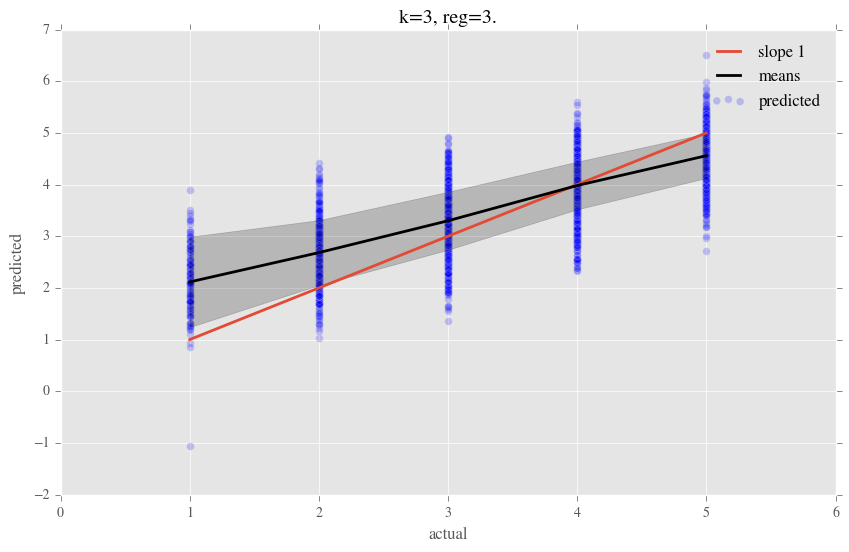

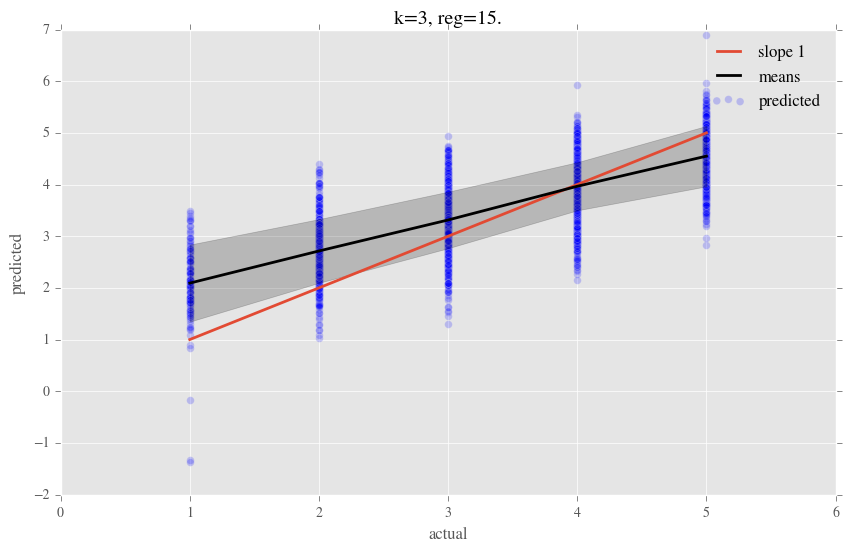

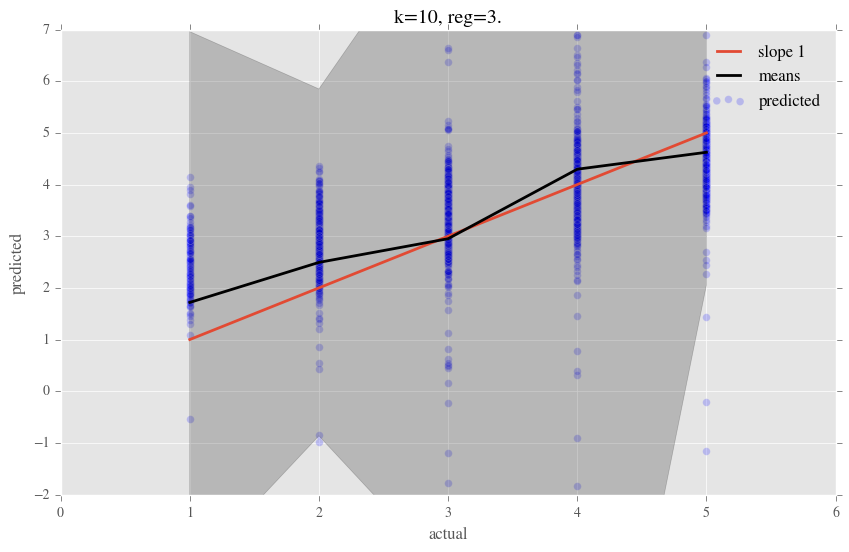

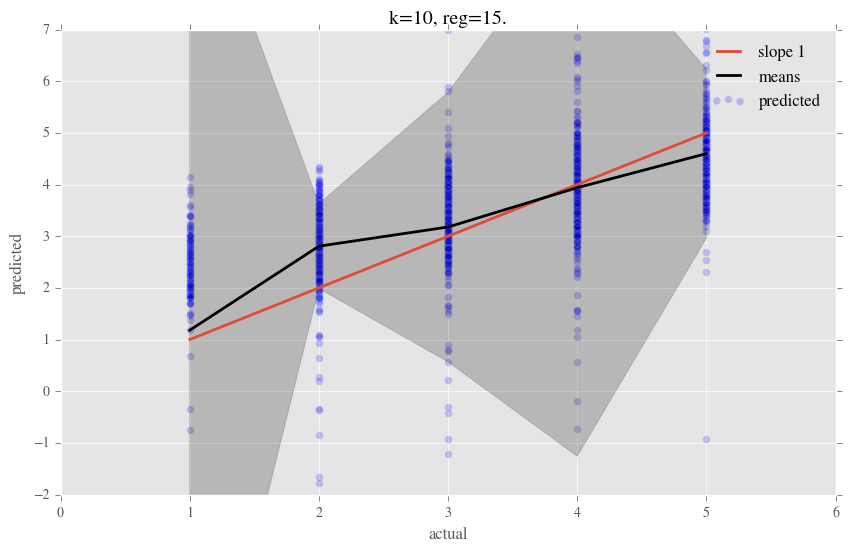

In [49]:
print "k=3, reg=3."
Make_Results_Plot(smalldf,3,3.)
plt.title("k=3, reg=3.")

print "k=3, reg=15."
Make_Results_Plot(smalldf,3,15.)
plt.title("k=3, reg=15.")

print "k=10, reg=3."
Make_Results_Plot(smalldf,10,3.)
plt.title("k=10, reg=3.")

print "k=10, reg=15."
Make_Results_Plot(smalldf,10,15.)
plt.title("k=10, reg=15.")

For k=3, the predicted values are quite well-behaved, with the exception of several predictions that have extremely large magnitudes. It appears that the predicted values are pulled into the mean star rating, which sits somewhere around 3.8, so ratings on the low end are overestimated, and similarly ratings on the high end underestimated. The regularization does not appear to have a strong effect when k = 3.

For k=10, the predicted values are much less stable, with many more extreme predictions. The means appear to track better with the true means. The regularization has a much more extreme, although indirect, effect on the appearance of the plot. Since regularization has stronger effects on similarity scores between restaurants that have small common support, we can see that increasing k makes the predictions more sensitive to the regularization because in a small dataset, the common support between a restaurant and it's 10-nearest one will be quite small.

Note that this example does not seem to follow the standard bias-variance tradeoff, where we would expect small k to give a unbiased estimates that capture the extremes, while we would expect large k to give biased estimates that pull extreme values toward the mean. A large reason for this failure for this example to capture this behavior is that we have defined similarity scores that can be positive or negative, and the bias-variance logic is based on the more standard setting where we average together values that have strictly positive weights. When you have negative weights, it's possible that the sum of $s_{ij}$'s in a neighborhood can get close to zero, making our estimator $\hat Y_{um}$ explode in the positive or negative direction since this would entail dividing by (nearly) zero. Thus for those restaurants where the denominator goes to 0 (more likely to happen at larger k as you have more chances of it there being more weights to add), the ratings are unstable, even numerically!

This problem is less pronounced in large datasets or with small k because the k-nearest restaurants are likely to have positive similarity with the current one. However, with small datasets, we can find that even with k relatively small (in this case, around 10), there are negative similarities in the k-neighborhood that make the estimator unstable. This sort of instability would be much less pronounced in the large dataset.

If we were to rescale the similarities to be positive, say between 0 and 1, the behavior of the estimator with respect to $k$ and $reg$ would be quite different. (SEE BELOW!)

2.4 Rescale the similarity (make sure it's positive)
------------
The wide wings we see above are in the error graph are due to small values of the denominator in the similarity sum. If you were writing a production recommender, using the ratings as we defined would be a very bad idea.

Indeed the very idea of nearest neighbor should engender in you the idea of distances; and distances should not be negative. Furthermore, you would not be able to use distances other than those implied by the correlation coefficient in the calculation of nearest neighbors (such as a Manhattan distance or Jacard similarity).

We can fix this for the case of perarson coefficient by just a simple rescaling to the 0-1 range!
$$ \rho \rightarrow \frac{\rho+1}{2} $$
This translates into changing the shrunk score:
$$ s \rightarrow \frac{s}{2} + \frac{f}{2} $$
where
$$ f = \frac{N_{common}}{N_{common}+reg} $$

Note that the new quantity is really an inverse distance, and thus we'll sort by its smallness as before.

In [36]:
def Knearest_Positive(restaurant_id, set_of_restaurants, dbase, k=7, reg=3.):
    """
    Given a restaurant_id, dataframe, and database, get a sorted list of the
    k most similar restaurants from the entire database.
    """
    similars=[]
    for other_rest_id in set_of_restaurants:
        if other_rest_id != restaurant_id:
            sim, nc=dbase.Get(restaurant_id, other_rest_id)
            ssim=Shrunk_Sim(sim, nc, reg=reg)
            similars.append((other_rest_id, ssim/2.0 + float(nc)/(float(nc)+reg), nc)) 
    similars=sorted(similars, key=itemgetter(1), reverse=True)
    return similars[0:k]

def Knearest_Amongst_Userrated_Positive(restaurant_id, user_id, df, dbase, k=7, reg=3.):
    dfuser=df[df.user_id==user_id]
    bizsuserhasrated=dfuser.business_id.unique()
    return Knearest_Positive(restaurant_id, bizsuserhasrated, dbase, k=k, reg=reg)

In [43]:
def Rating_Positive(df, dbase, restaurant_id, user_id, k=7, reg=3.):
    mu=df.stars.mean()
    user_reviews=df[df.user_id==user_id]
    nsum=0.
    scoresum=0.
    nears=Knearest_Amongst_Userrated_Positive(restaurant_id, user_id, df, dbase, k=k, reg=reg)
    restaurant_mean=df[df.business_id==restaurant_id].business_avg.values[0]
    user_mean=user_reviews.user_avg.values[0]
    scores=[]
    for r,s_old,nc in nears:
        s=s_old/2.0
        shrink_factor=float(nc)/(float(nc)+reg) #f
        s=s+shrink_factor/2.0
        scoresum=scoresum+s
        scores.append(s)
        r_reviews_row=user_reviews[user_reviews['business_id']==r]
        r_stars=r_reviews_row.stars.values[0]
        r_avg=r_reviews_row.business_avg.values[0]
        rminusb=(r_stars - (r_avg + user_mean - mu))
        nsum=nsum + s*rminusb
    baseline=(user_mean + restaurant_mean - mu)
    if scoresum > 0.:
        val = nsum/scoresum + baseline
    else:
        val = baseline
    return val
    

In [50]:
def Make_Results_Plot_Positive(df,k,reg):
    uid=smalldf.user_id.values
    bid=smalldf.business_id.values
    actual=smalldf.stars.values
    predicted=np.zeros(len(actual))
    counter=0
    for user_id, biz_id in zip(uid,bid):
        predicted[counter]=Rating_Positive(smalldf, db, biz_id, user_id, k=k, reg=reg)
        counter=counter+1
    Compare_Results(actual, predicted, ylow=-2, yhigh=7)

We change the limits to make the bias-variance comparison more visible. The regularizer is set to 1 to reduce the regularization to something small, rather than something optimal. To make things more extreme, try k=15 rather than k=10.

k=2, reg=1.
fraction between -2 and 7 rating 1.0
k=2, reg=15.
fraction between -2 and 7 rating 1.0
k=15, reg=1.
fraction between -2 and 7 rating 1.0
k=15, reg=15.
fraction between -2 and 7 rating 1.0


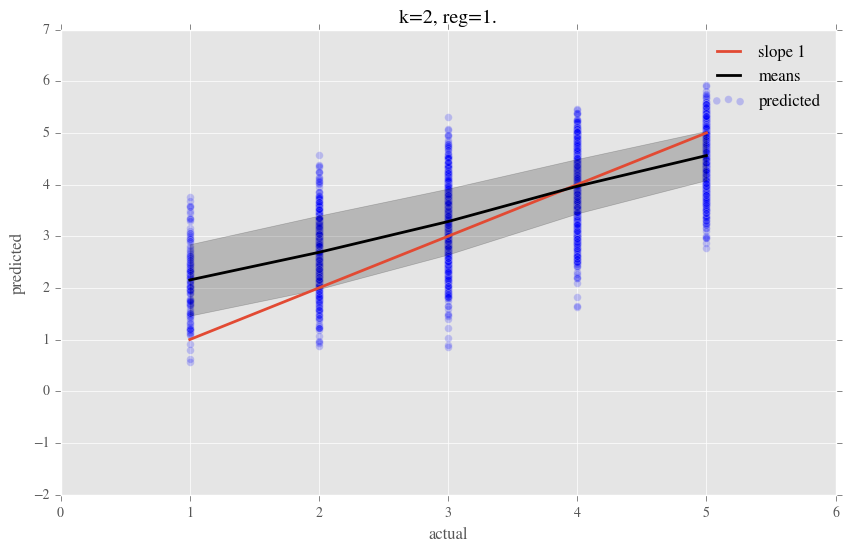

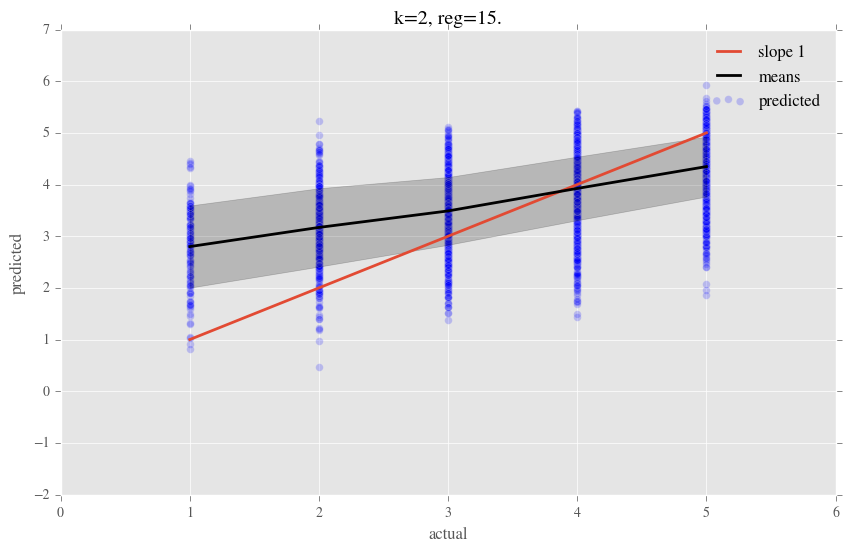

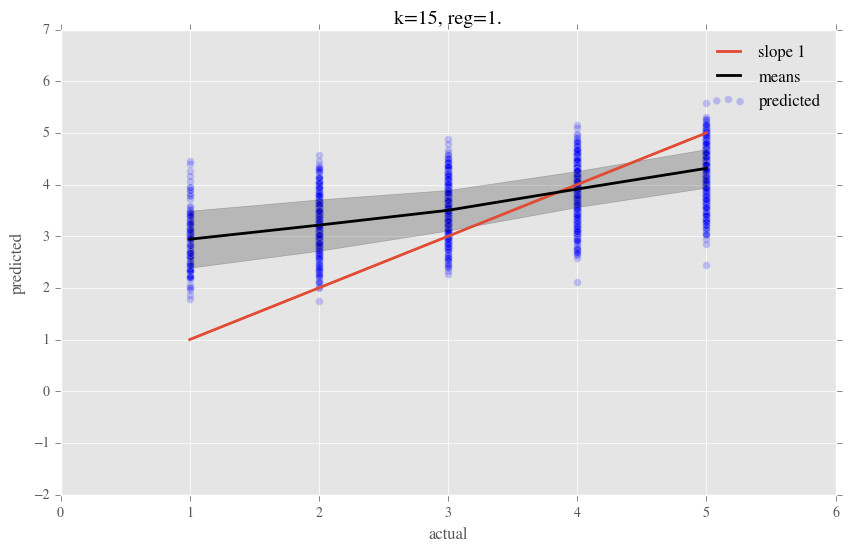

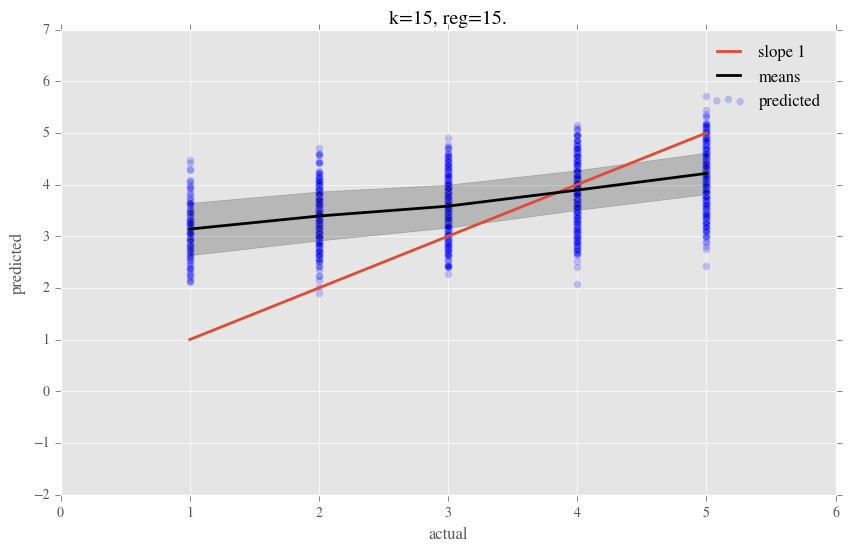

In [51]:
print "k=2, reg=1."
Make_Results_Plot_Positive(smalldf, 2, 1.)
plt.title("k=2, reg=1.")

print "k=2, reg=15."
Make_Results_Plot_Positive(smalldf, 2, 15.)
plt.title("k=2, reg=15.")

print "k=15, reg=1."
Make_Results_Plot_Positive(smalldf, 15, 1.)
plt.title("k=15, reg=1.")

print "k=15, reg=15."
Make_Results_Plot_Positive(smalldf, 15, 15.)
plt.title("k=15, reg=15.")

Observations:
- At low regularization, at low k (variance limit), the predictions (black curve) follow the red line more than at high k (bias limit). This is due to the bias limit pulling the extreme groups of ratings in towards the mean of all the reviews. **Increasing bias decreases the variation between the rating group**, resulting in a flatter black curve. 
- As k goes up, the precision (as measured by the width of the grey region, the variance within rating groups) gets smaller.
- Increasing regularization in the low k (variance limit) actually increass the bias because it tends to push things towards the center. 

**The process for choosing the nearest neighbor paramter `k` with a  fixed regularization parameter `reg`=3:**

Use K-fold cross-validation.
- Randomly partition the data in to $K$ equally sized folds, making sure that each fold includes at least one rating for each restaurant and one rating by each user. 
- For each value of `k`, and for each fold, we could repeat the procedure above for predicting user ratings by computing similarities using $K-1$ of the folds to compute similarities and computing the prediction error in the held out fold. 
- Choose the `k` with the smallest average prediction error across the folds, and recompute the recommender on the whole dataset using the chosen value of `k`. 

If we wanted to both choose a good value for `k` and check how well we could expect the result to generalize, we could divide the dataset into $K+1$ folds, and keep the last fold out as a verification set. We could perform the cross-validation above on $K$ folds to select `k`, then upon selecting `k` use all $K$ folds to create a recommender, and see how well this recommender predicted ratings in the final validation set.

3. Model based recommendations
==================
Use Gibbs sampler to write a recommendar that uses Bayesian techniques to impute ratings. 

In the previous section we implemented a procedure (a set of instructions for processing data) for giving recommendations and predicting user ratings for restaurants. This procedure involved a number of arbitrary choices -- for example, the particular measure of similarity between restaurants, or the weighting scheme for constructing a predicted rating. It also gave no sense of uncertainty -- in the case of giving recommendations, there was no statement about how we would expect the ranking from the procedure to compare to the user's true opinions of restaurants, and in the case of predicting ratings, there was no confidence interval for the prediction.

It is possible in repeated applications of the above procedure to see how it performs in the long run. Based on this long-run performance we could potentially justify certain functional choices and compute measurements of uncertainty. **This framework of proposing a procedure first, then evaluating its performance in real or hypothetical replications of the experiment is an example of a frequentist approach to a problem.** One aspect of the frequentist approach is that the proposed procedure does not necessarily have to be derived from a model (although it often is). While this means that a proposed procedure may be more flexible or robust than a model-based procedure, it also means that there is no natural way to justify certain functional choices or construct uncertainty estimates.

In contrast, **the Bayesian approach to a problem always begins with a probablistic model for how the data were generated.** Assuming this model is true, the posterior distribution over unknown quantities (either parameters to be estimated or unobserved data to be predicted) gives a single coherent expression of what the observed data tell us about the unknowns. By summarizing the posterior distribution, we can derive the exact functional form of a procedure for constructing estimates or predictions. We call a procedure derived from this Bayesian approach a Bayes rule (not to be confused with Bayes' Theorem). Using the posterior distribution, we can also give a sense of how uncertain we are about the estimate or prediction we have constructed.

**Outline:**
- Take a Bayesian approach here, and construct our estimates and predictions from summaries of the posterior distribution of the model's parameters, which we will compute using a Gibbs sampler. 
- Give measures of uncertainty based on the posterior distribution. 
- Evaluate predictions from this approach in the same way we evaluated predictions from the KNN procedure. 

3.1 The latent factor model
---------------
We can think of latent factors as properties of restaurants (e.g., spiciness of food or price) that users have a positive or negative preference for. We do not observe these factors or the users' preferences directly, but we assume that they affect how users tend to rate restaurants. For example, if a restaurant serves a lot of spicy food and a user dislikes spicy food, then the restaurant would have a high "spiciness" factor, and the user would have a strongly negative preference, resulting in a prediction of a low rating. Note that if users have similar preferences, then according to the model, they will behave similarly, and likewise, if restaurants have similar latent factors, they will be rated similarly by similar users. Latent factors thus give us an intuitive way to specify a generative model the obeys the central dogma.

**One issue that comes up with latent factor models is determining how many latent factors to include.** There may be a number of different unmeasured properties that affect ratings in different ways -- for example, in addition to the spiciness factor above, there may also be a price factor that affects how users rate a restaurant. We deal with the problem of choosing the number of latent factors to include in the same way we deal with choosing $K$ in a $K$-nearest neighbors problem.


**Rating model specification**

To make this model concrete, we can write down our probability model as a generative process. 

First, we define the following quantities:

Counts:
- $L$: The number of latent factors.
- $U$: The number of users.
- $M$: The number of items (restaurants).
- $N$: The number of observed ratings.

Data:
- $Y_{um}$: The star rating given to restaurant $m$ by user $u$.
- $Y$: The full collection of observed star ratings.

Item-specific quantities:
- $\gamma_m$: An item-specific parameter vector of length $L+1$. The first element of $\gamma_m$, denoted $\gamma_m[0]$ is the item-specific bias. The remaining $L$ elements of $\gamma_m$, denoted $\gamma_m[1:]$, are the latent factors associated with item $m$.
- $\Gamma$: An $M$ by $L+1$ matrix where the $m$th row is $\gamma_m$.

User-specific quantities:
- $\theta_u$: A user-specific parameter vector of length $L+1$. The first element of $\theta_u$, denoted $\theta_u[0]$ is the user-specific bias. The remaining $L$ elements of $\theta_u$, denoted $\theta_u[1:]$, are user $u$'s preferences for the latent factors.
- $\Theta$: A $U$ by $L+1$ matrix where the $u$th row is $\theta_u$.

Global quantities:

- $\mu$: The overall ratings mean.
- $\sigma$: The residual variance of ratings after the mean, bias terms, and latent factors have been taken into account.

Using these quantities, we can specify our model for each rating $Y_{um}$ similarly to a linear regression:
$$Y_{um} = \mu + \theta_{u}[0] + \gamma_{m}[0] + \theta_{u}[1:]^{\top}\gamma_{m}[1:] + \epsilon_{um}$$
where
$$\epsilon_{um} \sim N(0, \sigma).$$
Note that while this looks like a linear regression, it is of a slightly different form because the latent factor term involves the product of two unknowns. This is like a linear regression where we forgot to measure some covariates.

We also assume the following priors on the user-specific and item-specific parameters:
$$
\begin{align*}
\gamma_m \sim MVN(\mathbf 0, \Lambda_\gamma^{-1})\\
\theta_u \sim MVN(\mathbf 0, \Lambda_\theta^{-1}),
\end{align*}
$$
where $MVN$ means **multivariate normal**, $\mathbf 0$ is vector of length $L+1$ filled with zeros, and $\Lambda_\theta^{-1}$ and $\Lambda_\gamma^{-1}$ are $L+1 \times L+1$ covariance matrices. $\mu$ and $\sigma$ also have priors, but they are not relevant to your task so we won't write them here.

**Goal for this model**

Using this model, we want to make inference about all of the quantities that, if we knew them, would allow us to sample $Y_{um}$ for any user and any item. These quantities are $\mu$, $\sigma$, and the elements of $\Theta$ and $\Gamma$.

**Given the goal specified above, how many quantities (counting a vector of $L$ items as $L$ quantities) are we trying to make inference about? Express your answer in terms of the variables in the "Counts" section above.**

There are $$U \times (L+1) + M \times (L+1) + 2$$ quantities to estimate.

3.2 Gibbs sampling from the posterior
-------------------
Our goal is to compute the posterior distribution over the unknowns $\mu$, $\sigma$, $\Gamma$, and $\Theta$ given $Y$, which reflects how much we know about these quantities given the data we have observed. We write this distribution as $P(\mu, \sigma, \Gamma, \Theta \mid Y)$.

The most general way to learn about the posterior distribution is to sample from it. This can be challenging, particularly in problems that are very high dimensional (see your answer to the question above). One strategy for sampling from high-dimensional distributions is **Gibbs sampling**, which we discussed in class and lab.

Gibbs sampling breaks down the posterior probability distribution into blocks of unknowns, and samples iteratively from each block assuming that the values of the other blocks (and the data) are known and fixed. In this case, we will break down the posterior distribution into blocks of $\mu$, $\sigma$, each vector $\gamma_m$, and each vector $\theta_u$. We have already implemented the draws for $\mu$ and $\sigma$. You will need to implement the draws for each $\gamma_m$ and each $\theta_u$. Luckily, the structures of these draws are similar, so you will only need to implement two functions.

1. The distribution of the item-specific parameters $\gamma_{m'}$ for item $m'$, assuming that all of the other unknowns are fixed. 
$$Y_{um'} - \mu - \theta_{u}[0] = \gamma_{m'}[0] + \theta_{u}[1:]^{\top}\gamma_{m'}[1:] + \epsilon_{um'}.$$
Notice that, because we assume that $\theta_{u}$ is known, this equation now fits cleanly into the form of a linear regression, where $\gamma_{m'}$ is the vector of unknown coefficients. This means that the posterior distribution for $\gamma_{m'}$ conditional on everything else is the same as the posterior for the coefficients of a Bayesian linear regression of $(Y_{um'} - \mu - \theta_{u}[0])$ on $\theta_{u}[1:]$ and an intercept.

Let's denote the set of users who rated item $m'$ as $(u_1, \cdots, u_g)$. Then, we can define the following vector and matrix:
$$\begin{align*}
Y_{m'} = \left(\begin{array}{c} Y_{u_1m'}-\mu-\theta_{u_1}[0]\\ \vdots \\ Y_{u_gm'}-\mu-\theta_{u_g}[0]\end{array}\right), \qquad
X_{m'} & \left(\begin{array}{cc} 1 & \theta_{u_1}[1:]^\top \\ \vdots & \vdots \\ 1 & \theta_{u_g}[1:]^\top\end{array}\right),
\end{align*}$$
where $Y_{m'}$ is a vector of length $g$ and $X_{m'}$ is a $g \times L+1$ matrix.

The draw from $\gamma_{m'}$ given everything else then has the form: $$ \gamma_{m'} \mid Y, \mu, \sigma, \Gamma_{-m'}, \Theta \sim MVN\left(Q_{m'}^{-1} \frac{1}{\sigma^2}X_{m'}^\top Y_{m'}, Q_{m'}^{-1}\right)$$ where $$ Q_{m'} = \left(\frac{1}{\sigma^2}X_{m'}^\top X_{m'} + \Lambda_\gamma\right).$$

2. The distribution of the user-specific parameters for user $u'$, imagining that all of the other unknowns are fixed.

We can denote the set of items rated by user $u'$ as $(m_1, \cdots, m_g)$ and define the vector and matrix: 
$$\begin{align*} 
Y_{u'} = \left(\begin{array}{c} Y_{u'm_1}-\mu-\gamma_{m_1}[0] \\ \vdots \\ Y{u'm_g}-\mu-\gamma_{m_g}[0]\end{array}\right), \qquad 
X_{u'} = \left(\begin{array}{cc} 1 & \gamma_{m_1}[1:]^\top \\ \vdots & \vdots \\ 1 & \gamma_{m_g}[1:]^\top\end{array}\right), 
\end{align*}$$
where $Y_{u'}$ is a vector of length $g$ and $X_{u'}$ is a $g \times L+1$ matrix.

The draw from $\theta_{u'}$ given everything else has the form: $$ \theta_{u'} \mid Y, \mu, \sigma, \Gamma, \Theta_{-u'} \sim MVN\left(Q_{u'}^{-1} \frac{1}{\sigma^2}X_{u'}^\top Y_{u'}, Q_{u'}^{-1}\right)$$ where $$ Q_{u'}= \left(\frac{1}{\sigma^2}X_{u'}^\top X_{u'} + \Lambda_\theta\right).$$


In [58]:
"""
Function
--------
gamma_m_draw

Draw a single sample from the conditional posterior distribution
of gamma_m.

Inputs
-------
X_m: A g-by-L+1 matrix, defined above. 
Y_m: A 1D vector of length g, defined above.
sig2: Residual _variance_, as defined above.
Lambda_gamma: Prior precision matrix.

Outputs
--------
Single draw from conditional posterior, defined above.
"""
#Item-specific parameters given all else
def Gamma_M_Draw(X_m, Y_m, sig2, Lambda_gamma):
    # Compute matrices that define conditional posterior.
    Q_m_inv = np.linalg.inv(np.dot(X_m.T, X_m)/sig2+Lambda_gamma)
    XtY= np.dot(X_m.T, Y_m)
    # Draw item-specific parameters
    return np.random.multivariate_normal(np.dot(Q_m_inv, XtY)/sig2, Q_m_inv)

In [67]:
"""
Function
--------
theta_u_draw

Draw a single sample from the conditional posterior distribution
of gamma_m.

Inputs
-------
X_u: A g-by-L+1 matrix, defined above. 
Y_u: A 1D vector of length g, defined above.
sig2: Residual _variance_, as defined above.
Lambda_theta: Prior precision matrix.

Outputs
--------
Single draw from conditional posterior, defined above.
"""
def Theta_U_Draw(X_u, Y_u, sig2, Lambda_theta):
    # Compute matrices that define conditional posterior.
    Q_u_inv = np.linalg.inv(np.dot(X_u.T, X_u)/sig2+Lambda_theta)
    XtY = np.dot(X_u.T, Y_u)
    # Draw user-specific parameters
    return np.random.multivariate_normal(np.dot(Q_u_inv,XtY)/sig2,Q_u_inv)

Here is the Gibbs sampler skeleton that your functions fit into. Look over the structure to see how for each draw from the posterior, the sampler iterates through $\mu$, $\sigma$, $\gamma_m$ for each item, and $\theta_u$ for each user.

In [69]:
"""
Function
--------
factor_gibbs

Runs a gibbs sampler to infer mean, variance, user-specific, and item-specific
parameters.

Inputs
-------
data: A dataframe containing ratings data.
L: Dimension of latent factors.
maxit: Number of samples to draw from posterior.
Lambda_theta_diag: Hyperparameter controlling regularization of Theta.
Lambda_gamma_diag: Hyperparameter controlling regularization of Gamma.
progress: if true, print iteration number every 100 iterations.

Outputs
--------
Dictionary with elements
mu: Draws of mu. 1D array of length maxiter.
sig2: Draws of sig2, residual _variance_. 1D array of length maxiter.
theta: Draws of Theta. U-by-L-by-maxiter array.
gamma: Draws of Gamma. M-by-L-by-maxiter array.
EY: Draws of fitted values of Y. N-by-maxiter array.
"""
def Factor_Gibbs(data, L, maxit, Lambda_theta_diag, Lambda_gamma_diag, progress=True):
    data=data.copy()
    N=data.shape[0]
    
    #Create indices that allow us to map users and restaurants to rows
    #in parameter vectors.
    uusers, uidx = np.unique(data.user_id, return_inverse=True)
    uitems, midx = np.unique(data.business_id, return_inverse=True)
    
    nusers = uusers.size
    nitems = uitems.size
    
    #Add numerical indices to dataframe.
    data["uidx"]=uidx
    data["midx"]=midx
    
    #Group observations by user and by business.
    ugroups = data.groupby("uidx")
    mgroups = data.groupby("midx")
    
    all_avg = data.stars.mean()
    u_avg = ugroups.stars.mean()
    m_avg = mgroups.stars.mean()
    
    #Initialize parameters and set up data structures for holding draws.
    #Overall mean
    mu = all_avg
    mu_draws = np.zeros(maxit)
    #Residual variance
    sig2 = 0.5
    sig2_draws = np.zeros(maxit)
    
    #Matrix of user-specific bias and L latent factors.
    theta = np.zeros([nusers, L+1])
    theta[:,0] = u_avg-all_avg
    theta_draws = np.zeros([nusers, L+1, maxit])
    
    #Matrix of item-specific bias and L latent factors.
    gamma = np.zeros([nitems, L+1])
    gamma[:,0] = m_avg-all_avg
    gamma_draws = np.zeros([nitems, L+1, maxit])
    
    #Matrix for holding the expected number of stars
    #for each observation at each draw from the posterior.
    EY_draws = np.zeros([data.shape[0], maxit])
    
    #Inverse covariance matrices from the prior on each theta_u and gamma_b. 
    #These are diagonal, like Ridge regression.
    Lambda_theta = np.eye(L+1)*Lambda_theta_diag
    Lambda_gamma = np.eye(L+1)*Lambda_gamma_diag
    
    #*********************************************************
    #Main sampler code
    for i in range(maxit):
        if i%100==0 and progress:
            print "Sampling in progress...", i," done..."
            
        #The entire regression equation except for the overall mean.
        nomu = np.sum(theta[data.uidx,1:]*gamma[data.midx,1:], axis=1)+\
                theta[data.uidx,0]+gamma[data.midx,0]
        
        #Compute the expectation of each observation given the current 
        #parameter values.
        EY_draws[:,i]=mu+nomu
        
        #Draw overall mean from a normal distribution
        mu = np.random.normal(np.mean(data.stars-nomu), np.sqrt(sig2/N))
        #Draw overall residual variance from a scaled inverse-Chi squared distribution.
        sig2 = np.sum(np.power(data.stars-nomu-mu,2))/np.random.chisquare(N-2)
        
        #For each item
        for mi,itemdf in mgroups:
            #Gather relevant observations, and subtract out overall mean and
            #user-specific biases, which we are holding fixed.
            Y_m = itemdf.stars-mu-theta[itemdf.uidx,0]
            #Build the regression design matrix implied by holding user factors
            #fixed. 
            X_m = np.hstack((np.ones([itemdf.shape[0],1]),
                            theta[itemdf.uidx,1:]))
            gamma[mi,:] = Gamma_M_Draw(X_m, Y_m, sig2, Lambda_gamma)
            
        #For each item
        for ui,userdf in ugroups:
            #Gaither relevant observations, and subtract out overall mean
            #and business-specific biases, which we are holding fixed.
            Y_u = userdf.stars-mu-gamma[userdf.midx,0]
            #Build the regression design matrix implied by holding business
            #factors fixed.
            X_u = np.hstack((np.ones([userdf.shape[0],1]),
                            gamma[userdf.midx,1:]))
            theta[ui,:] = Theta_U_Draw(X_u, Y_u, sig2, Lambda_theta)
            
        #Record draws
        mu_draws[i] = mu
        sig2_draws[i] = sig2
        theta_draws[:,:,i] = theta
        gamma_draws[:,:,i] = gamma
        
    return {"mu": mu_draws, "sig2": sig2_draws,
           "theta": theta_draws, "gamma": gamma_draws,
           "EY": EY_draws}

3.3 Posterior summaries
------------
Once you have posterior draws from the sampler, the most natural thing to do is to compute the posterior mean of each quantity you are intersted in. To do this, we simply need to take the average value of each quantity across the samples drawn from the sampler. Before taking the average, however, we will want to ignore the first 20-30% of samples because these correspond the **burnin** period, the time during which the sampler is still looking for the main meat of the distribution.

**Latent factor recommender**

Now that you have the Gibbs sampler, draw 1000 samples from the posterior distribution using a two-dimensional latent factor and prior precisions `Lambda_theta_diag` and `Lambda_gamma_diag` both equal to 0.1.

Compute the posterior mean of the fitted values for each $Y_{um}$, eliminating the first 200 samples. Call these the prediction. These constitute our recommendations. True to the bayesian paradigm, we dont just have mean predictions, but entire distributions. But currently we are only interested in the means.

In [70]:
gibbs_out = Factor_Gibbs(smalldf, 2, 1000, 0.1, 0.1)
burnin = 200
predicted = np.mean(gibbs_out['EY'][:,burnin:], axis=1)

Sampling in progress... 0  done...
Sampling in progress... 100  done...
Sampling in progress... 200  done...
Sampling in progress... 300  done...
Sampling in progress... 400  done...
Sampling in progress... 500  done...
Sampling in progress... 600  done...
Sampling in progress... 700  done...
Sampling in progress... 800  done...
Sampling in progress... 900  done...


Visualize the predictions against the observed data. 

fraction between -2 and 7 rating 1.0


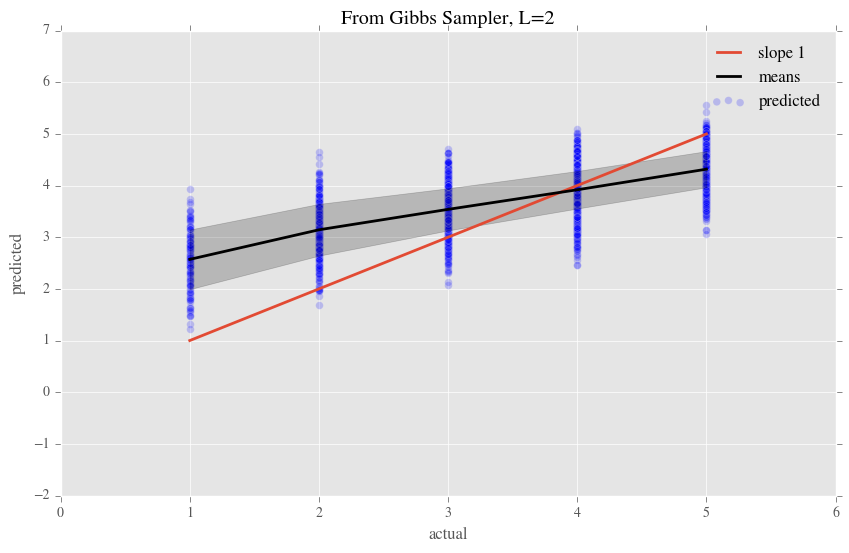

In [72]:
Compare_Results(smalldf.stars.values, predicted, ylow=-2, yhigh=7, title="From Gibbs Sampler, L=2")

**How do the fitted values compare to those from the KNN procedure?**
The results from the latent factor model appear to be better-behaved than those from the KNN procedure with negative similarities (Section 2.3). If we compare to the KNN procedure with strictly positive weights (Section 2.4), we see again that the recommenders make comparable predictions, although the latent factor model again appears to fit slightly better than at both the bias or variance limits of the KNN procedure.  

There is also a bias-variance tradeoff here. In this case, it appears that we have proposed a model that is too simple (thus close to the bias limit) because of how the ratings are pulled in toward the data mean. In this case, proposing more latent factors increases the flexibility of the model, and thus moves us toward the variance limit. Thus, the plot suggests that we may want to reduce the bias at the cost of increasing variance, for example by considering a latent factor model with more factors (say, $L = 15$) to obtain a better fit.

Sampling in progress... 0  done...
Sampling in progress... 100  done...
Sampling in progress... 200  done...
Sampling in progress... 300  done...
Sampling in progress... 400  done...
Sampling in progress... 500  done...
Sampling in progress... 600  done...
Sampling in progress... 700  done...
Sampling in progress... 800  done...
Sampling in progress... 900  done...
fraction between -2 and 7 rating 1.0


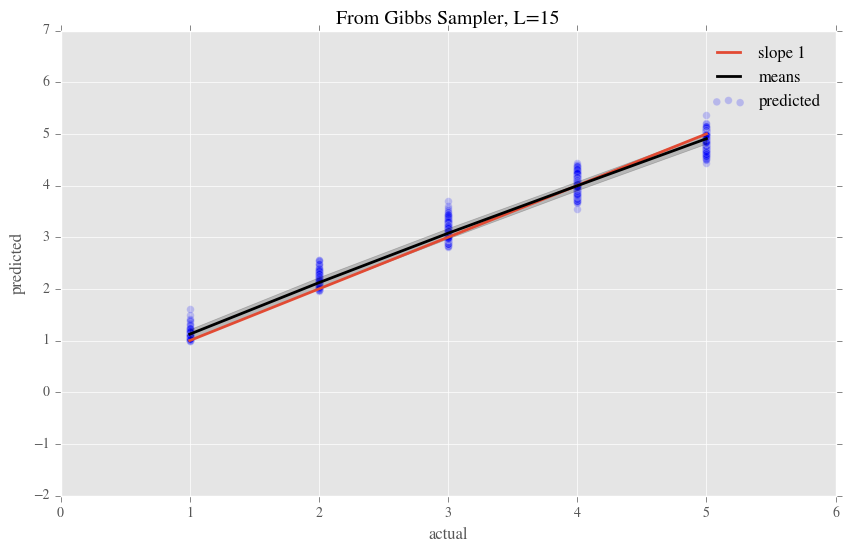

In [73]:
gibbs_out = Factor_Gibbs(smalldf, 15, 1000, 0.1, 0.1)
burnin = 200
predicted = np.mean(gibbs_out['EY'][:,burnin:], axis=1)
Compare_Results(smalldf.stars.values, predicted, ylow=-2, yhigh=7, title="From Gibbs Sampler, L=15")

The fit here looks much better, both in terms of tracking the red line and in terms of the within-group precision (as measured by the grey band). A model at the variance limit (that is, one that is extremely overfit) with low bias would have a mean line that tracks exactly with the green line and an almost non-existent gray area. To tell whether this plot represents simply a good prediction model or a one that is woefully overfit, we would need to look at out-of-sample data.